In [329]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import pipeline as pip
from sklearn import preprocessing as pre
from sklearn import compose as com
from sklearn import impute as imp
from catboost import CatBoostRegressor


import xgboost.sklearn as xgb
import warnings
warnings.filterwarnings("ignore", message="is_sparse is deprecated")

In [4]:
df_holidays_events = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/holidays_events.csv')
df_oil = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/oil.csv')
df_stores = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/stores.csv')
df_train = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/train.csv')
df_transactions = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/transactions.csv')
df_test = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/test.csv')

In [8]:
print('holidays_events.shape->', df_holidays_events.shape)
print('oil.shape->', df_oil.shape)
print('stores.shape->', df_stores.shape)
print('train.shape->', df_train.shape)
print('train.shape->', df_transactions.shape)

holidays_events.shape-> (350, 6)
oil.shape-> (1218, 2)
stores.shape-> (54, 5)
train.shape-> (3000888, 6)
train.shape-> (83488, 3)


In [11]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [12]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [13]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [14]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [15]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [16]:
df_test.shape

(28512, 5)

In [36]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [30]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

In [164]:
df_merged = pd.merge(df_train, df_stores, on='store_nbr', how='left')
df_merged = pd.merge(df_merged, df_oil, on='date', how='left')
df_merged = pd.merge(df_merged, df_transactions, on=['date', 'store_nbr'], how='left')

In [165]:
df_merged.tail()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,transactions
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2155.0
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0,Quito,Pichincha,B,6,47.57,2155.0


In [166]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 12 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  transactions  float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(4)
memory usage: 274.7+ MB


<Axes: >

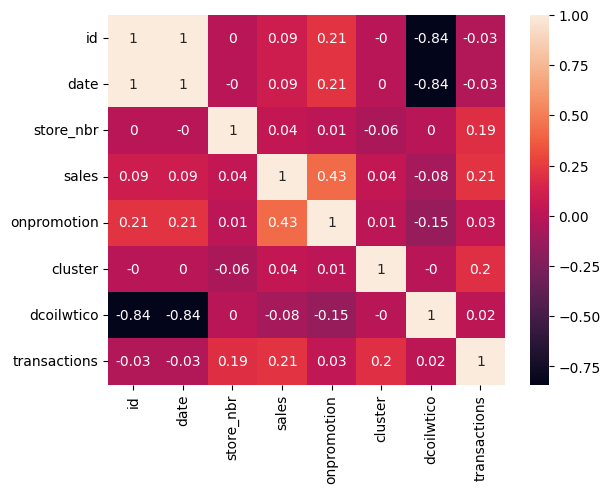

In [167]:
sns.heatmap( np.round(df_merged.select_dtypes(exclude='object').corr(), 2), annot=True)

In [168]:
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


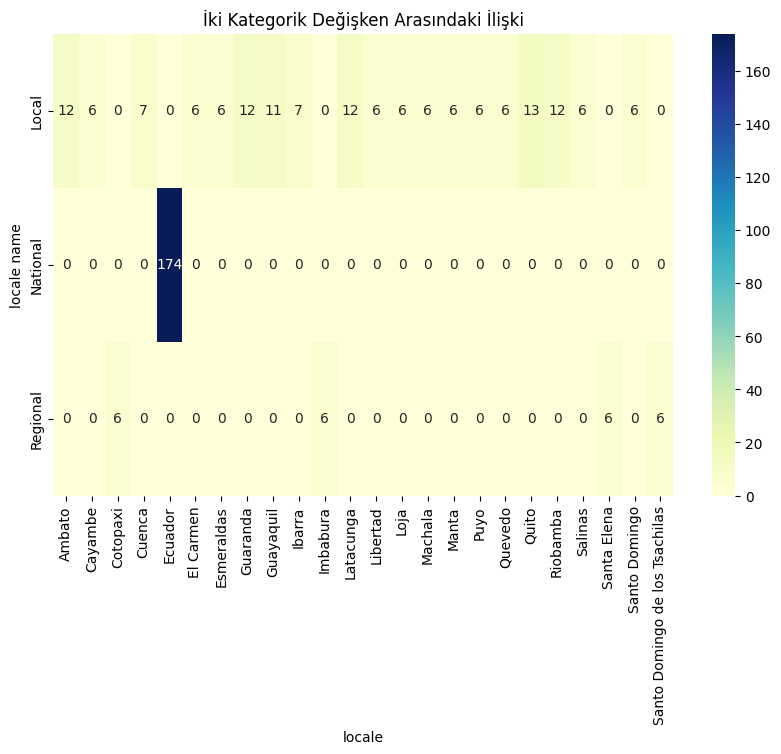

In [169]:
# İki kategorik değişkenin birleşim frekanslarını hesapla
cross_tab = pd.crosstab(df_holidays_events['locale'], df_holidays_events['locale_name'])

# Heatmap oluştur
plt.figure(figsize=(10, 6))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu')
plt.title('İki Kategorik Değişken Arasındaki İlişki')
plt.xlabel('locale')
plt.ylabel('locale name')
plt.show()

In [170]:
df_holidays_events['locale_name'].value_counts()

locale_name
Ecuador                           174
Quito                              13
Riobamba                           12
Guaranda                           12
Latacunga                          12
Ambato                             12
Guayaquil                          11
Cuenca                              7
Ibarra                              7
Salinas                             6
Loja                                6
Santa Elena                         6
Santo Domingo de los Tsachilas      6
Quevedo                             6
Manta                               6
Esmeraldas                          6
Cotopaxi                            6
El Carmen                           6
Santo Domingo                       6
Machala                             6
Imbabura                            6
Puyo                                6
Libertad                            6
Cayambe                             6
Name: count, dtype: int64

In [171]:
df_merged['city'].value_counts()

city
Quito            1000296
Guayaquil         444576
Santo Domingo     166716
Cuenca            166716
Latacunga         111144
Manta             111144
Machala           111144
Ambato            111144
Quevedo            55572
Esmeraldas         55572
Loja               55572
Libertad           55572
Playas             55572
Daule              55572
Babahoyo           55572
Cayambe            55572
Salinas            55572
Puyo               55572
Guaranda           55572
Ibarra             55572
Riobamba           55572
El Carmen          55572
Name: count, dtype: int64

In [172]:
df_merged['state'].value_counts()

state
Pichincha                         1055868
Guayas                             611292
Santo Domingo de los Tsachilas     166716
Azuay                              166716
Manabi                             166716
Cotopaxi                           111144
Tungurahua                         111144
Los Rios                           111144
El Oro                             111144
Chimborazo                          55572
Imbabura                            55572
Bolivar                             55572
Pastaza                             55572
Santa Elena                         55572
Loja                                55572
Esmeraldas                          55572
Name: count, dtype: int64

In [173]:
df_merged.isnull().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
type                 0
cluster              0
dcoilwtico      928422
transactions    245784
dtype: int64

In [174]:
df_merged['date'].nunique()

1684

In [175]:
#since we merged df_transactions via store_nbr and date, unique numbers of null date does not mean anything
df_merged[df_merged.transactions.isnull()]['date'].nunique()

1566

In [176]:
#since we dont have the values for the dates of the test data, we can ignore transactions
df_transactions.tail()

,date,store_nbr,transactions
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932
83487,2017-08-15,54,802


In [177]:
df_merged.drop('transactions', axis=1,inplace=True)

In [178]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [179]:
df_merged[df_merged.dcoilwtico.notnull()]['date'].nunique()

1163

In [180]:
df_merged[df_merged.dcoilwtico.isnull()]['date'].nunique()

521

In [181]:
df_merged.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN


In [182]:
df_merged.isna().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
city                0
state               0
type                0
cluster             0
dcoilwtico     928422
dtype: int64

In [183]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [184]:
indices = pd.date_range(df_train.date.min(), df_train.date.max(), freq="D").difference(df_oil.date)
print('Missing indices\n:', indices)



Missing indices
: DatetimeIndex(['2013-01-05', '2013-01-06', '2013-01-12', '2013-01-13',
               '2013-01-19', '2013-01-20', '2013-01-26', '2013-01-27',
               '2013-02-02', '2013-02-03',
               ...
               '2017-07-15', '2017-07-16', '2017-07-22', '2017-07-23',
               '2017-07-29', '2017-07-30', '2017-08-05', '2017-08-06',
               '2017-08-12', '2017-08-13'],
              dtype='datetime64[ns]', length=482, freq=None)


In [185]:
def date_parse(df):
    df['date'] = pd.to_datetime(df['date'])
    df['DayOfWeek'] = df['date'].dt.dayofweek
    #df['Week'] = df['date'].dt.week
    df['Month'] = df['date'].dt.month
    df["Quarter"] = df["date"].dt.quarter
    df["Year"] = df["date"].dt.year
    #df["WeekOfYear"] = df["date"].dt.weekofyear
    return df

In [186]:
def cycle_encode(data, cols):
    for col in cols:
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
    return data

In [187]:
df_merged = date_parse(df_merged)
df_merged = cycle_encode(df_merged, ['DayOfWeek', 'Month', 'Quarter'])

In [188]:
df_merged.drop(['DayOfWeek', 'Month', 'Quarter'], axis=1, inplace=True)

In [189]:
df_merged

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,Year,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
1,1,2013-01-01,1,BABY CARE,0.000,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
2,2,2013-01-01,1,BEAUTY,0.000,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
3,3,2013-01-01,1,BEVERAGES,0.000,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
4,4,2013-01-01,1,BOOKS,0.000,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.500000,0.866025,1.0,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,Quito,Pichincha,B,6,47.57,2017,0.866025,0.5,-0.866025,-0.500000,-1.0,-1.836970e-16
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Quito,Pichincha,B,6,47.57,2017,0.866025,0.5,-0.866025,-0.500000,-1.0,-1.836970e-16
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,Quito,Pichincha,B,6,47.57,2017,0.866025,0.5,-0.866025,-0.500000,-1.0,-1.836970e-16
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Quito,Pichincha,B,6,47.57,2017,0.866025,0.5,-0.866025,-0.500000,-1.0,-1.836970e-16


In [190]:
df_merged = df_merged.set_index('date')

In [197]:
df_merged.drop(['id'], axis=1, inplace=True)

In [198]:
#Missing dates
indices = pd.date_range(df_merged.index.min(), df_merged.index.max(), freq="D").difference(df_merged.index)
print('Missing indices\n:', indices)

Missing indices
: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


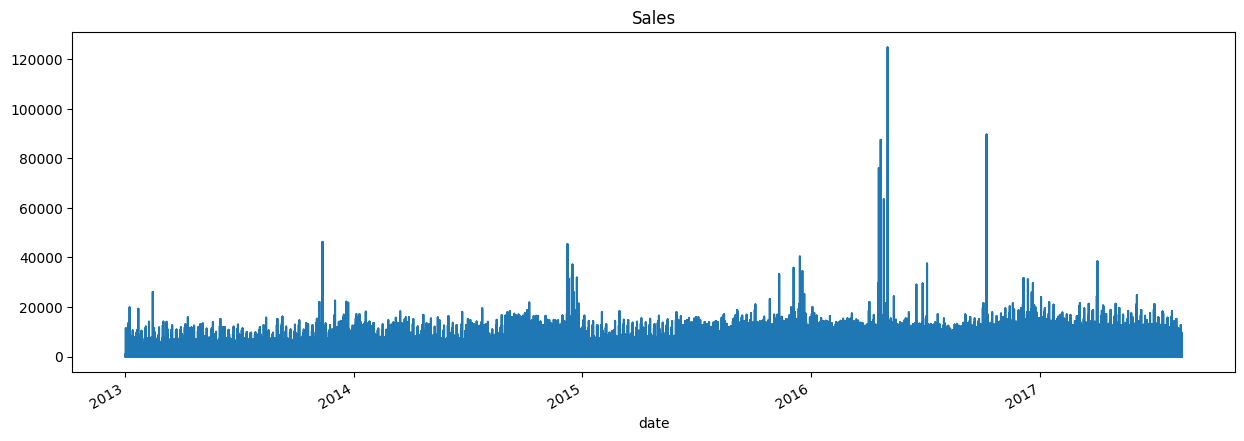

In [199]:
fig, ax = plt.subplots(figsize=(15, 5))
df_merged.sales.plot(ax=ax, label='Training Set', title='Sales')
plt.show()

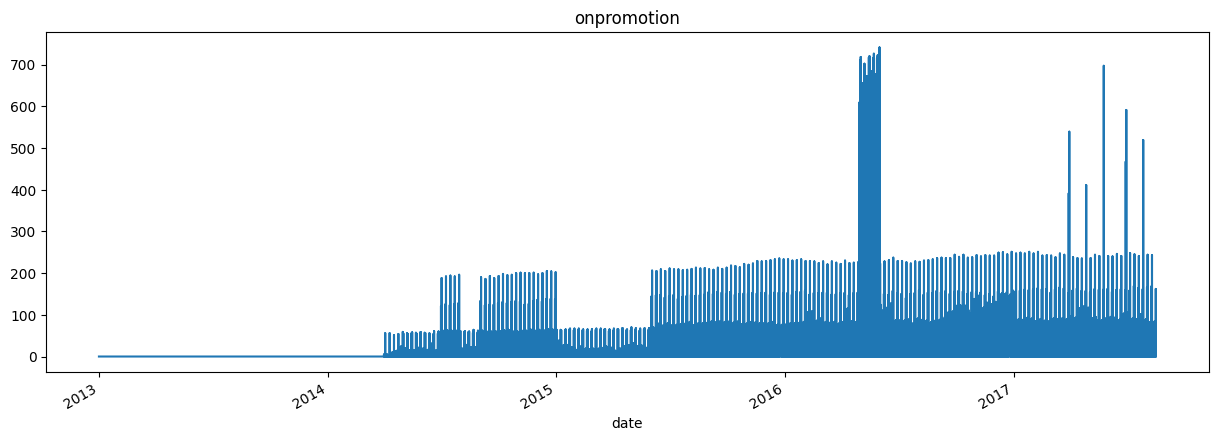

In [200]:
fig, ax = plt.subplots(figsize=(15, 5))
df_merged.onpromotion.plot(ax=ax, label='Training Set', title='onpromotion')
plt.show()

In [201]:
len(df_merged['store_nbr'].value_counts())

54

In [202]:
df_merged['family'].value_counts()

family
AUTOMOTIVE                    90936
HOME APPLIANCES               90936
SCHOOL AND OFFICE SUPPLIES    90936
PRODUCE                       90936
PREPARED FOODS                90936
POULTRY                       90936
PLAYERS AND ELECTRONICS       90936
PET SUPPLIES                  90936
PERSONAL CARE                 90936
MEATS                         90936
MAGAZINES                     90936
LIQUOR,WINE,BEER              90936
LINGERIE                      90936
LAWN AND GARDEN               90936
LADIESWEAR                    90936
HOME CARE                     90936
HOME AND KITCHEN II           90936
BABY CARE                     90936
HOME AND KITCHEN I            90936
HARDWARE                      90936
GROCERY II                    90936
GROCERY I                     90936
FROZEN FOODS                  90936
EGGS                          90936
DELI                          90936
DAIRY                         90936
CLEANING                      90936
CELEBRATION          

In [203]:
df_merged.head()

,store_nbr,family,sales,onpromotion,city,state,type,cluster,dcoilwtico,Year,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos
date,,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17


In [242]:
df_merged['store_nbr'] = df_merged['store_nbr'].astype('object')

In [243]:
X = df_merged.drop('sales', axis=1)
y = df_merged['sales']

In [244]:
cat_columns = X.select_dtypes(include='object').columns.values
num_columns = X.select_dtypes(exclude='object').columns.values

In [245]:
X.head()

,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,Year,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos
date,,,,,,,,,,,,,,,
2013-01-01,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BEAUTY,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BEVERAGES,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17
2013-01-01,1,BOOKS,0,Quito,Pichincha,D,13,NaN,2013,0.866025,0.5,0.5,0.866025,1.0,6.123234e-17


In [246]:
len(X['family'].value_counts()), len(X['city'].value_counts()),len(X['state'].value_counts()),len(X['store_nbr'].value_counts())

(33, 22, 16, 54)

In [330]:
pip_num = pip.Pipeline([
    ('scaler', pre.StandardScaler()),
    ('imputer', imp.SimpleImputer())
])

pip_cat = pip.Pipeline([
    ('encoder', pre.OneHotEncoder(handle_unknown='ignore')),
])

ct = com.ColumnTransformer([
    ('num', pip_num, num_columns),
    ('cat', pip_cat, cat_columns)
])

pip_final = pip.Pipeline([
    ('ct', ct),
    ('model', CatBoostRegressor())
])

# set the parameters
params = {
    'model__learning_rate': [0.01, 0.1],

}

grid = GridSearchCV(pip_final,
                    param_grid = params,
                    scoring = 'r2',
                    cv = TimeSeriesSplit(n_splits=3),
                   )

In [331]:
grid.fit(X,y)

0:	learn: 758.3476811	total: 78.7ms	remaining: 1m 18s
1:	learn: 753.2032427	total: 99.6ms	remaining: 49.7s
2:	learn: 748.1266791	total: 120ms	remaining: 39.8s
3:	learn: 743.1338502	total: 138ms	remaining: 34.4s
4:	learn: 738.2041303	total: 155ms	remaining: 30.9s
5:	learn: 733.3315505	total: 176ms	remaining: 29.1s
6:	learn: 728.5320316	total: 193ms	remaining: 27.4s
7:	learn: 723.7883333	total: 213ms	remaining: 26.5s
8:	learn: 719.1085117	total: 235ms	remaining: 25.9s
9:	learn: 714.4883556	total: 253ms	remaining: 25s
10:	learn: 709.9308631	total: 270ms	remaining: 24.3s
11:	learn: 705.4228866	total: 292ms	remaining: 24.1s
12:	learn: 700.9854369	total: 311ms	remaining: 23.6s
13:	learn: 696.6130996	total: 329ms	remaining: 23.2s
14:	learn: 692.2832520	total: 349ms	remaining: 22.9s
15:	learn: 688.0201025	total: 366ms	remaining: 22.5s
16:	learn: 683.8226549	total: 385ms	remaining: 22.3s
17:	learn: 679.6655033	total: 405ms	remaining: 22.1s
18:	learn: 675.5661165	total: 425ms	remaining: 21.9s
19

158:	learn: 423.9732956	total: 3.25s	remaining: 17.2s
159:	learn: 423.3625431	total: 3.26s	remaining: 17.1s
160:	learn: 422.7507135	total: 3.29s	remaining: 17.1s
161:	learn: 422.1019380	total: 3.31s	remaining: 17.1s
162:	learn: 421.5104034	total: 3.32s	remaining: 17.1s
163:	learn: 420.9298101	total: 3.34s	remaining: 17s
164:	learn: 420.3386830	total: 3.36s	remaining: 17s
165:	learn: 419.7726988	total: 3.38s	remaining: 17s
166:	learn: 419.1939589	total: 3.39s	remaining: 16.9s
167:	learn: 418.6389635	total: 3.41s	remaining: 16.9s
168:	learn: 418.0942735	total: 3.43s	remaining: 16.9s
169:	learn: 417.5309677	total: 3.45s	remaining: 16.8s
170:	learn: 416.9998378	total: 3.46s	remaining: 16.8s
171:	learn: 416.4781502	total: 3.48s	remaining: 16.8s
172:	learn: 415.9389736	total: 3.5s	remaining: 16.7s
173:	learn: 415.3928968	total: 3.52s	remaining: 16.7s
174:	learn: 414.8158944	total: 3.54s	remaining: 16.7s
175:	learn: 414.2899593	total: 3.56s	remaining: 16.7s
176:	learn: 413.7896535	total: 3.58

313:	learn: 368.8812502	total: 6.19s	remaining: 13.5s
314:	learn: 368.7072390	total: 6.21s	remaining: 13.5s
315:	learn: 368.2705028	total: 6.23s	remaining: 13.5s
316:	learn: 367.9748392	total: 6.25s	remaining: 13.5s
317:	learn: 367.6096644	total: 6.27s	remaining: 13.4s
318:	learn: 367.2478129	total: 6.29s	remaining: 13.4s
319:	learn: 366.8927995	total: 6.31s	remaining: 13.4s
320:	learn: 366.7259785	total: 6.33s	remaining: 13.4s
321:	learn: 366.3544830	total: 6.35s	remaining: 13.4s
322:	learn: 365.9897812	total: 6.37s	remaining: 13.3s
323:	learn: 365.7726478	total: 6.39s	remaining: 13.3s
324:	learn: 365.6032880	total: 6.41s	remaining: 13.3s
325:	learn: 365.4357520	total: 6.42s	remaining: 13.3s
326:	learn: 365.2709439	total: 6.44s	remaining: 13.3s
327:	learn: 365.1363402	total: 6.46s	remaining: 13.2s
328:	learn: 364.8710098	total: 6.48s	remaining: 13.2s
329:	learn: 364.6873449	total: 6.5s	remaining: 13.2s
330:	learn: 364.5134485	total: 6.52s	remaining: 13.2s
331:	learn: 364.3637240	total

476:	learn: 342.0866420	total: 9.34s	remaining: 10.2s
477:	learn: 342.0181219	total: 9.36s	remaining: 10.2s
478:	learn: 341.9574123	total: 9.38s	remaining: 10.2s
479:	learn: 341.7933145	total: 9.4s	remaining: 10.2s
480:	learn: 341.7295955	total: 9.42s	remaining: 10.2s
481:	learn: 341.4992900	total: 9.44s	remaining: 10.1s
482:	learn: 341.4355952	total: 9.45s	remaining: 10.1s
483:	learn: 341.3282835	total: 9.47s	remaining: 10.1s
484:	learn: 341.1785519	total: 9.49s	remaining: 10.1s
485:	learn: 340.9689608	total: 9.51s	remaining: 10.1s
486:	learn: 340.8278679	total: 9.52s	remaining: 10s
487:	learn: 340.6887583	total: 9.54s	remaining: 10s
488:	learn: 340.5664504	total: 9.56s	remaining: 9.99s
489:	learn: 340.4972490	total: 9.58s	remaining: 9.97s
490:	learn: 340.3859171	total: 9.6s	remaining: 9.96s
491:	learn: 340.2651182	total: 9.62s	remaining: 9.94s
492:	learn: 340.1418266	total: 9.64s	remaining: 9.91s
493:	learn: 340.0610092	total: 9.66s	remaining: 9.9s
494:	learn: 340.0004886	total: 9.68

631:	learn: 324.1110350	total: 12.3s	remaining: 7.14s
632:	learn: 324.0201348	total: 12.3s	remaining: 7.12s
633:	learn: 323.8887482	total: 12.3s	remaining: 7.11s
634:	learn: 323.7941038	total: 12.3s	remaining: 7.08s
635:	learn: 323.7241144	total: 12.3s	remaining: 7.06s
636:	learn: 323.6504633	total: 12.4s	remaining: 7.04s
637:	learn: 323.5578855	total: 12.4s	remaining: 7.03s
638:	learn: 323.4491316	total: 12.4s	remaining: 7s
639:	learn: 323.2807346	total: 12.4s	remaining: 6.99s
640:	learn: 323.2416069	total: 12.4s	remaining: 6.97s
641:	learn: 323.1405513	total: 12.5s	remaining: 6.95s
642:	learn: 322.9904144	total: 12.5s	remaining: 6.93s
643:	learn: 322.9011720	total: 12.5s	remaining: 6.91s
644:	learn: 322.7822426	total: 12.5s	remaining: 6.89s
645:	learn: 322.6736731	total: 12.5s	remaining: 6.87s
646:	learn: 322.5565674	total: 12.5s	remaining: 6.85s
647:	learn: 322.4302320	total: 12.6s	remaining: 6.83s
648:	learn: 322.3616713	total: 12.6s	remaining: 6.81s
649:	learn: 322.2158041	total: 

790:	learn: 309.6094732	total: 15.2s	remaining: 4.02s
791:	learn: 309.5602139	total: 15.2s	remaining: 4s
792:	learn: 309.4786744	total: 15.3s	remaining: 3.98s
793:	learn: 309.3876144	total: 15.3s	remaining: 3.96s
794:	learn: 309.3219174	total: 15.3s	remaining: 3.94s
795:	learn: 309.2607302	total: 15.3s	remaining: 3.92s
796:	learn: 309.1702745	total: 15.3s	remaining: 3.9s
797:	learn: 309.0669682	total: 15.4s	remaining: 3.89s
798:	learn: 308.9787248	total: 15.4s	remaining: 3.87s
799:	learn: 308.8490794	total: 15.4s	remaining: 3.85s
800:	learn: 308.7508517	total: 15.4s	remaining: 3.83s
801:	learn: 308.6851541	total: 15.4s	remaining: 3.81s
802:	learn: 308.6516088	total: 15.4s	remaining: 3.79s
803:	learn: 308.5094169	total: 15.5s	remaining: 3.77s
804:	learn: 308.4616405	total: 15.5s	remaining: 3.75s
805:	learn: 308.3999205	total: 15.5s	remaining: 3.73s
806:	learn: 308.3400566	total: 15.5s	remaining: 3.71s
807:	learn: 308.2518219	total: 15.5s	remaining: 3.69s
808:	learn: 308.1998581	total: 1

944:	learn: 298.7632061	total: 18.2s	remaining: 1.06s
945:	learn: 298.7047632	total: 18.2s	remaining: 1.04s
946:	learn: 298.6336321	total: 18.2s	remaining: 1.02s
947:	learn: 298.5740137	total: 18.2s	remaining: 999ms
948:	learn: 298.4430479	total: 18.2s	remaining: 980ms
949:	learn: 298.3953413	total: 18.3s	remaining: 961ms
950:	learn: 298.2755290	total: 18.3s	remaining: 941ms
951:	learn: 298.2485086	total: 18.3s	remaining: 922ms
952:	learn: 298.1988633	total: 18.3s	remaining: 903ms
953:	learn: 298.1353127	total: 18.3s	remaining: 884ms
954:	learn: 298.0883637	total: 18.3s	remaining: 864ms
955:	learn: 298.0410969	total: 18.4s	remaining: 845ms
956:	learn: 297.9997285	total: 18.4s	remaining: 826ms
957:	learn: 297.8827521	total: 18.4s	remaining: 807ms
958:	learn: 297.7950432	total: 18.4s	remaining: 788ms
959:	learn: 297.6423505	total: 18.4s	remaining: 768ms
960:	learn: 297.5747692	total: 18.5s	remaining: 749ms
961:	learn: 297.5070048	total: 18.5s	remaining: 730ms
962:	learn: 297.4486802	tota

104:	learn: 567.2103613	total: 3.99s	remaining: 34s
105:	learn: 565.8964646	total: 4.02s	remaining: 33.9s
106:	learn: 564.6090821	total: 4.06s	remaining: 33.9s
107:	learn: 563.3186136	total: 4.1s	remaining: 33.8s
108:	learn: 562.0246312	total: 4.14s	remaining: 33.8s
109:	learn: 560.7674454	total: 4.17s	remaining: 33.8s
110:	learn: 559.5341323	total: 4.21s	remaining: 33.7s
111:	learn: 558.3319916	total: 4.25s	remaining: 33.7s
112:	learn: 557.1327296	total: 4.29s	remaining: 33.7s
113:	learn: 555.9483675	total: 4.33s	remaining: 33.7s
114:	learn: 554.7676969	total: 4.38s	remaining: 33.7s
115:	learn: 553.6132428	total: 4.41s	remaining: 33.6s
116:	learn: 552.5033403	total: 4.45s	remaining: 33.6s
117:	learn: 551.3715534	total: 4.49s	remaining: 33.6s
118:	learn: 550.2513379	total: 4.53s	remaining: 33.5s
119:	learn: 549.1526974	total: 4.57s	remaining: 33.5s
120:	learn: 548.0734081	total: 4.6s	remaining: 33.4s
121:	learn: 546.9926786	total: 4.64s	remaining: 33.4s
122:	learn: 545.9322474	total: 4

257:	learn: 469.5981413	total: 9.8s	remaining: 28.2s
258:	learn: 469.3091138	total: 9.83s	remaining: 28.1s
259:	learn: 469.0332538	total: 9.87s	remaining: 28.1s
260:	learn: 468.7188688	total: 9.9s	remaining: 28s
261:	learn: 468.4298418	total: 9.93s	remaining: 28s
262:	learn: 468.1069272	total: 9.97s	remaining: 27.9s
263:	learn: 467.7753790	total: 10s	remaining: 27.9s
264:	learn: 467.5124162	total: 10s	remaining: 27.9s
265:	learn: 467.2120508	total: 10.1s	remaining: 27.8s
266:	learn: 466.9037688	total: 10.1s	remaining: 27.8s
267:	learn: 466.5982650	total: 10.2s	remaining: 27.7s
268:	learn: 466.2662862	total: 10.2s	remaining: 27.7s
269:	learn: 466.0142220	total: 10.2s	remaining: 27.7s
270:	learn: 465.5831868	total: 10.3s	remaining: 27.6s
271:	learn: 465.2614027	total: 10.3s	remaining: 27.6s
272:	learn: 465.0205760	total: 10.4s	remaining: 27.6s
273:	learn: 464.7296447	total: 10.4s	remaining: 27.5s
274:	learn: 464.4415272	total: 10.4s	remaining: 27.5s
275:	learn: 464.1731629	total: 10.5s	r

412:	learn: 435.8877109	total: 15.6s	remaining: 22.2s
413:	learn: 435.6934411	total: 15.6s	remaining: 22.1s
414:	learn: 435.4261990	total: 15.7s	remaining: 22.1s
415:	learn: 435.3319334	total: 15.7s	remaining: 22.1s
416:	learn: 435.2004082	total: 15.8s	remaining: 22s
417:	learn: 434.9397047	total: 15.8s	remaining: 22s
418:	learn: 434.7427031	total: 15.8s	remaining: 22s
419:	learn: 434.6520729	total: 15.9s	remaining: 21.9s
420:	learn: 434.4884373	total: 15.9s	remaining: 21.9s
421:	learn: 434.2899154	total: 16s	remaining: 21.9s
422:	learn: 434.1879363	total: 16s	remaining: 21.8s
423:	learn: 433.9934644	total: 16s	remaining: 21.8s
424:	learn: 433.8390165	total: 16.1s	remaining: 21.7s
425:	learn: 433.7415310	total: 16.1s	remaining: 21.7s
426:	learn: 433.6323470	total: 16.1s	remaining: 21.7s
427:	learn: 433.4442374	total: 16.2s	remaining: 21.6s
428:	learn: 433.3011115	total: 16.2s	remaining: 21.6s
429:	learn: 433.0613697	total: 16.3s	remaining: 21.6s
430:	learn: 432.9441737	total: 16.3s	rem

570:	learn: 412.7065361	total: 21.6s	remaining: 16.2s
571:	learn: 412.5782638	total: 21.6s	remaining: 16.2s
572:	learn: 412.4872194	total: 21.7s	remaining: 16.1s
573:	learn: 412.3553794	total: 21.7s	remaining: 16.1s
574:	learn: 412.2502441	total: 21.7s	remaining: 16.1s
575:	learn: 412.1294163	total: 21.8s	remaining: 16s
576:	learn: 412.0276477	total: 21.8s	remaining: 16s
577:	learn: 411.8871030	total: 21.8s	remaining: 15.9s
578:	learn: 411.6325190	total: 21.9s	remaining: 15.9s
579:	learn: 411.5749889	total: 21.9s	remaining: 15.9s
580:	learn: 411.4391473	total: 21.9s	remaining: 15.8s
581:	learn: 411.3481029	total: 22s	remaining: 15.8s
582:	learn: 411.1749693	total: 22s	remaining: 15.8s
583:	learn: 411.0497397	total: 22.1s	remaining: 15.7s
584:	learn: 410.8335703	total: 22.1s	remaining: 15.7s
585:	learn: 410.6541484	total: 22.1s	remaining: 15.6s
586:	learn: 410.4892629	total: 22.2s	remaining: 15.6s
587:	learn: 410.3539543	total: 22.2s	remaining: 15.6s
588:	learn: 410.2376869	total: 22.2s

726:	learn: 394.2117439	total: 27.4s	remaining: 10.3s
727:	learn: 394.0894681	total: 27.4s	remaining: 10.2s
728:	learn: 394.0276060	total: 27.4s	remaining: 10.2s
729:	learn: 393.8735304	total: 27.5s	remaining: 10.2s
730:	learn: 393.8081958	total: 27.5s	remaining: 10.1s
731:	learn: 393.6803376	total: 27.6s	remaining: 10.1s
732:	learn: 393.5619475	total: 27.6s	remaining: 10.1s
733:	learn: 393.4586004	total: 27.6s	remaining: 10s
734:	learn: 393.2992547	total: 27.7s	remaining: 9.98s
735:	learn: 393.2311779	total: 27.7s	remaining: 9.94s
736:	learn: 393.1283084	total: 27.7s	remaining: 9.9s
737:	learn: 393.0263037	total: 27.8s	remaining: 9.86s
738:	learn: 392.9145429	total: 27.8s	remaining: 9.83s
739:	learn: 392.7915379	total: 27.9s	remaining: 9.79s
740:	learn: 392.7251782	total: 27.9s	remaining: 9.76s
741:	learn: 392.6469214	total: 27.9s	remaining: 9.72s
742:	learn: 392.4919460	total: 28s	remaining: 9.68s
743:	learn: 392.3825542	total: 28s	remaining: 9.64s
744:	learn: 392.1898930	total: 28.1

879:	learn: 380.0137678	total: 33.2s	remaining: 4.52s
880:	learn: 379.9201311	total: 33.2s	remaining: 4.48s
881:	learn: 379.8668014	total: 33.2s	remaining: 4.44s
882:	learn: 379.8170909	total: 33.3s	remaining: 4.41s
883:	learn: 379.7117016	total: 33.3s	remaining: 4.37s
884:	learn: 379.6149303	total: 33.3s	remaining: 4.33s
885:	learn: 379.5338117	total: 33.4s	remaining: 4.29s
886:	learn: 379.4819055	total: 33.4s	remaining: 4.25s
887:	learn: 379.4078506	total: 33.4s	remaining: 4.22s
888:	learn: 379.3058810	total: 33.5s	remaining: 4.18s
889:	learn: 379.2146076	total: 33.5s	remaining: 4.14s
890:	learn: 379.1251281	total: 33.6s	remaining: 4.11s
891:	learn: 379.0744959	total: 33.6s	remaining: 4.07s
892:	learn: 378.9484699	total: 33.6s	remaining: 4.03s
893:	learn: 378.8733065	total: 33.7s	remaining: 3.99s
894:	learn: 378.7894056	total: 33.7s	remaining: 3.96s
895:	learn: 378.6894259	total: 33.8s	remaining: 3.92s
896:	learn: 378.6087276	total: 33.8s	remaining: 3.88s
897:	learn: 378.5287883	tota

36:	learn: 824.9875009	total: 1.99s	remaining: 51.9s
37:	learn: 821.1159594	total: 2.04s	remaining: 51.7s
38:	learn: 817.3035870	total: 2.09s	remaining: 51.6s
39:	learn: 813.5667696	total: 2.15s	remaining: 51.6s
40:	learn: 809.8873815	total: 2.21s	remaining: 51.6s
41:	learn: 806.2598827	total: 2.26s	remaining: 51.6s
42:	learn: 802.7114212	total: 2.31s	remaining: 51.5s
43:	learn: 799.1999266	total: 2.36s	remaining: 51.3s
44:	learn: 795.7278912	total: 2.42s	remaining: 51.3s
45:	learn: 792.2956554	total: 2.47s	remaining: 51.3s
46:	learn: 788.8773382	total: 2.52s	remaining: 51.1s
47:	learn: 785.5474328	total: 2.58s	remaining: 51.1s
48:	learn: 782.2269922	total: 2.63s	remaining: 51s
49:	learn: 778.9588221	total: 2.68s	remaining: 50.9s
50:	learn: 775.7583929	total: 2.73s	remaining: 50.8s
51:	learn: 772.6087523	total: 2.79s	remaining: 50.8s
52:	learn: 769.4741523	total: 2.83s	remaining: 50.7s
53:	learn: 766.3889571	total: 2.89s	remaining: 50.6s
54:	learn: 763.3290053	total: 2.94s	remaining: 5

191:	learn: 572.5842160	total: 10.4s	remaining: 43.8s
192:	learn: 572.0794838	total: 10.5s	remaining: 43.7s
193:	learn: 571.5394174	total: 10.5s	remaining: 43.6s
194:	learn: 570.9638751	total: 10.6s	remaining: 43.6s
195:	learn: 570.3058848	total: 10.6s	remaining: 43.5s
196:	learn: 569.6431736	total: 10.7s	remaining: 43.4s
197:	learn: 569.0830931	total: 10.7s	remaining: 43.4s
198:	learn: 568.5977737	total: 10.8s	remaining: 43.3s
199:	learn: 568.0173596	total: 10.8s	remaining: 43.3s
200:	learn: 567.4856195	total: 10.9s	remaining: 43.2s
201:	learn: 566.8497398	total: 10.9s	remaining: 43.1s
202:	learn: 566.3145658	total: 11s	remaining: 43s
203:	learn: 565.6862787	total: 11s	remaining: 43s
204:	learn: 565.0697735	total: 11.1s	remaining: 42.9s
205:	learn: 564.5767422	total: 11.1s	remaining: 42.8s
206:	learn: 564.1446474	total: 11.2s	remaining: 42.8s
207:	learn: 563.6445276	total: 11.2s	remaining: 42.7s
208:	learn: 563.1349249	total: 11.3s	remaining: 42.6s
209:	learn: 562.5368255	total: 11.3s

347:	learn: 517.9267390	total: 18.4s	remaining: 34.5s
348:	learn: 517.6842946	total: 18.5s	remaining: 34.4s
349:	learn: 517.5218000	total: 18.5s	remaining: 34.4s
350:	learn: 517.3381671	total: 18.6s	remaining: 34.3s
351:	learn: 517.1238066	total: 18.6s	remaining: 34.2s
352:	learn: 516.9162257	total: 18.7s	remaining: 34.2s
353:	learn: 516.7466288	total: 18.7s	remaining: 34.2s
354:	learn: 516.5372458	total: 18.8s	remaining: 34.1s
355:	learn: 516.3680293	total: 18.8s	remaining: 34s
356:	learn: 516.2306811	total: 18.9s	remaining: 34s
357:	learn: 516.0784361	total: 18.9s	remaining: 33.9s
358:	learn: 515.8693936	total: 19s	remaining: 33.9s
359:	learn: 515.5905312	total: 19s	remaining: 33.8s
360:	learn: 515.3725860	total: 19.1s	remaining: 33.7s
361:	learn: 515.1516044	total: 19.1s	remaining: 33.7s
362:	learn: 514.8195388	total: 19.2s	remaining: 33.6s
363:	learn: 514.6777181	total: 19.2s	remaining: 33.6s
364:	learn: 514.5201626	total: 19.3s	remaining: 33.5s
365:	learn: 514.3034790	total: 19.3s

502:	learn: 490.8439219	total: 26.4s	remaining: 26.1s
503:	learn: 490.5473031	total: 26.5s	remaining: 26.1s
504:	learn: 490.3223084	total: 26.6s	remaining: 26s
505:	learn: 490.2041820	total: 26.6s	remaining: 26s
506:	learn: 490.1052802	total: 26.7s	remaining: 25.9s
507:	learn: 489.9536554	total: 26.7s	remaining: 25.9s
508:	learn: 489.7775388	total: 26.8s	remaining: 25.8s
509:	learn: 489.6280194	total: 26.8s	remaining: 25.8s
510:	learn: 489.4422070	total: 26.9s	remaining: 25.7s
511:	learn: 489.3284595	total: 26.9s	remaining: 25.7s
512:	learn: 489.2419151	total: 27s	remaining: 25.6s
513:	learn: 489.0635093	total: 27s	remaining: 25.6s
514:	learn: 488.8818742	total: 27.1s	remaining: 25.5s
515:	learn: 488.7376848	total: 27.1s	remaining: 25.4s
516:	learn: 488.6638183	total: 27.2s	remaining: 25.4s
517:	learn: 488.5158494	total: 27.2s	remaining: 25.3s
518:	learn: 488.4071818	total: 27.3s	remaining: 25.3s
519:	learn: 488.3345242	total: 27.3s	remaining: 25.2s
520:	learn: 488.0426983	total: 27.4s

656:	learn: 470.3297577	total: 34.5s	remaining: 18s
657:	learn: 470.2487668	total: 34.5s	remaining: 17.9s
658:	learn: 470.1135343	total: 34.6s	remaining: 17.9s
659:	learn: 470.0606410	total: 34.6s	remaining: 17.8s
660:	learn: 469.9706421	total: 34.7s	remaining: 17.8s
661:	learn: 469.8649667	total: 34.7s	remaining: 17.7s
662:	learn: 469.8006363	total: 34.8s	remaining: 17.7s
663:	learn: 469.6659723	total: 34.8s	remaining: 17.6s
664:	learn: 469.5575385	total: 34.9s	remaining: 17.6s
665:	learn: 469.4904853	total: 34.9s	remaining: 17.5s
666:	learn: 469.3581421	total: 35s	remaining: 17.5s
667:	learn: 469.2651464	total: 35s	remaining: 17.4s
668:	learn: 469.1827841	total: 35.1s	remaining: 17.4s
669:	learn: 469.0916126	total: 35.1s	remaining: 17.3s
670:	learn: 468.9461306	total: 35.2s	remaining: 17.2s
671:	learn: 468.8532695	total: 35.2s	remaining: 17.2s
672:	learn: 468.7216568	total: 35.3s	remaining: 17.1s
673:	learn: 468.5276562	total: 35.3s	remaining: 17.1s
674:	learn: 468.3429147	total: 35.

810:	learn: 454.3475541	total: 42.4s	remaining: 9.88s
811:	learn: 454.2859100	total: 42.4s	remaining: 9.82s
812:	learn: 454.2030827	total: 42.5s	remaining: 9.77s
813:	learn: 454.1235597	total: 42.5s	remaining: 9.72s
814:	learn: 454.0365580	total: 42.6s	remaining: 9.67s
815:	learn: 453.9888285	total: 42.7s	remaining: 9.62s
816:	learn: 453.8898827	total: 42.7s	remaining: 9.56s
817:	learn: 453.8316653	total: 42.8s	remaining: 9.51s
818:	learn: 453.7708978	total: 42.8s	remaining: 9.46s
819:	learn: 453.6848586	total: 42.9s	remaining: 9.41s
820:	learn: 453.6190291	total: 42.9s	remaining: 9.36s
821:	learn: 453.5132820	total: 43s	remaining: 9.31s
822:	learn: 453.3898468	total: 43.1s	remaining: 9.26s
823:	learn: 453.2502186	total: 43.1s	remaining: 9.21s
824:	learn: 453.1168642	total: 43.2s	remaining: 9.16s
825:	learn: 453.0622510	total: 43.2s	remaining: 9.11s
826:	learn: 452.9100064	total: 43.3s	remaining: 9.06s
827:	learn: 452.8470128	total: 43.4s	remaining: 9.01s
828:	learn: 452.7495559	total:

963:	learn: 441.5587722	total: 50.2s	remaining: 1.88s
964:	learn: 441.4655910	total: 50.3s	remaining: 1.82s
965:	learn: 441.3539024	total: 50.3s	remaining: 1.77s
966:	learn: 441.2772063	total: 50.4s	remaining: 1.72s
967:	learn: 441.1937101	total: 50.4s	remaining: 1.67s
968:	learn: 441.1410880	total: 50.5s	remaining: 1.61s
969:	learn: 441.0745207	total: 50.5s	remaining: 1.56s
970:	learn: 441.0343431	total: 50.6s	remaining: 1.51s
971:	learn: 440.9249387	total: 50.7s	remaining: 1.46s
972:	learn: 440.8545731	total: 50.7s	remaining: 1.41s
973:	learn: 440.8043040	total: 50.8s	remaining: 1.35s
974:	learn: 440.7201663	total: 50.8s	remaining: 1.3s
975:	learn: 440.6378715	total: 50.9s	remaining: 1.25s
976:	learn: 440.5668319	total: 50.9s	remaining: 1.2s
977:	learn: 440.4785591	total: 51s	remaining: 1.15s
978:	learn: 440.3745126	total: 51s	remaining: 1.09s
979:	learn: 440.3014122	total: 51.1s	remaining: 1.04s
980:	learn: 440.2183531	total: 51.1s	remaining: 990ms
981:	learn: 440.1424825	total: 51.

124:	learn: 279.5495928	total: 2.32s	remaining: 16.3s
125:	learn: 279.1534107	total: 2.34s	remaining: 16.2s
126:	learn: 278.6754233	total: 2.36s	remaining: 16.2s
127:	learn: 278.2756887	total: 2.38s	remaining: 16.2s
128:	learn: 277.1264496	total: 2.4s	remaining: 16.2s
129:	learn: 276.5614968	total: 2.42s	remaining: 16.2s
130:	learn: 276.2346796	total: 2.43s	remaining: 16.1s
131:	learn: 275.6994731	total: 2.45s	remaining: 16.1s
132:	learn: 275.0580105	total: 2.47s	remaining: 16.1s
133:	learn: 274.6431307	total: 2.49s	remaining: 16.1s
134:	learn: 273.8962963	total: 2.51s	remaining: 16.1s
135:	learn: 273.6467629	total: 2.53s	remaining: 16.1s
136:	learn: 273.2990786	total: 2.54s	remaining: 16s
137:	learn: 272.5913052	total: 2.56s	remaining: 16s
138:	learn: 272.1863496	total: 2.58s	remaining: 16s
139:	learn: 271.9940873	total: 2.6s	remaining: 16s
140:	learn: 271.6420044	total: 2.62s	remaining: 16s
141:	learn: 271.3326169	total: 2.64s	remaining: 15.9s
142:	learn: 270.9459652	total: 2.65s	rem

280:	learn: 234.2855361	total: 5.22s	remaining: 13.4s
281:	learn: 234.1045691	total: 5.24s	remaining: 13.3s
282:	learn: 233.9438968	total: 5.26s	remaining: 13.3s
283:	learn: 233.8373358	total: 5.27s	remaining: 13.3s
284:	learn: 233.4377352	total: 5.29s	remaining: 13.3s
285:	learn: 233.2287482	total: 5.31s	remaining: 13.3s
286:	learn: 233.1134280	total: 5.33s	remaining: 13.2s
287:	learn: 233.0196476	total: 5.35s	remaining: 13.2s
288:	learn: 232.8711321	total: 5.37s	remaining: 13.2s
289:	learn: 232.7399910	total: 5.39s	remaining: 13.2s
290:	learn: 232.6208065	total: 5.41s	remaining: 13.2s
291:	learn: 232.5017886	total: 5.42s	remaining: 13.2s
292:	learn: 232.0978227	total: 5.44s	remaining: 13.1s
293:	learn: 231.9453834	total: 5.46s	remaining: 13.1s
294:	learn: 231.7100525	total: 5.48s	remaining: 13.1s
295:	learn: 231.5713697	total: 5.5s	remaining: 13.1s
296:	learn: 231.2971826	total: 5.52s	remaining: 13.1s
297:	learn: 231.1684963	total: 5.54s	remaining: 13s
298:	learn: 231.0575012	total: 

437:	learn: 214.2414017	total: 8.11s	remaining: 10.4s
438:	learn: 214.1831570	total: 8.13s	remaining: 10.4s
439:	learn: 214.1151193	total: 8.14s	remaining: 10.4s
440:	learn: 213.9612954	total: 8.16s	remaining: 10.3s
441:	learn: 213.8815274	total: 8.18s	remaining: 10.3s
442:	learn: 213.7671892	total: 8.2s	remaining: 10.3s
443:	learn: 213.7140398	total: 8.21s	remaining: 10.3s
444:	learn: 213.6675526	total: 8.23s	remaining: 10.3s
445:	learn: 213.5737882	total: 8.25s	remaining: 10.3s
446:	learn: 213.5273168	total: 8.27s	remaining: 10.2s
447:	learn: 213.4877749	total: 8.29s	remaining: 10.2s
448:	learn: 213.4330355	total: 8.31s	remaining: 10.2s
449:	learn: 213.3167099	total: 8.32s	remaining: 10.2s
450:	learn: 213.2340779	total: 8.34s	remaining: 10.2s
451:	learn: 213.0555710	total: 8.36s	remaining: 10.1s
452:	learn: 213.0079189	total: 8.38s	remaining: 10.1s
453:	learn: 212.8341655	total: 8.4s	remaining: 10.1s
454:	learn: 212.6775651	total: 8.42s	remaining: 10.1s
455:	learn: 212.6266719	total:

590:	learn: 203.0698008	total: 11.2s	remaining: 7.78s
591:	learn: 203.0274524	total: 11.3s	remaining: 7.76s
592:	learn: 202.9541089	total: 11.3s	remaining: 7.75s
593:	learn: 202.9093989	total: 11.3s	remaining: 7.73s
594:	learn: 202.8579173	total: 11.3s	remaining: 7.71s
595:	learn: 202.8346467	total: 11.3s	remaining: 7.69s
596:	learn: 202.7805658	total: 11.4s	remaining: 7.67s
597:	learn: 202.7347263	total: 11.4s	remaining: 7.65s
598:	learn: 202.6179523	total: 11.4s	remaining: 7.64s
599:	learn: 202.5345595	total: 11.4s	remaining: 7.62s
600:	learn: 202.4796954	total: 11.4s	remaining: 7.6s
601:	learn: 202.4405108	total: 11.5s	remaining: 7.58s
602:	learn: 202.4084464	total: 11.5s	remaining: 7.57s
603:	learn: 202.3774090	total: 11.5s	remaining: 7.55s
604:	learn: 202.3463431	total: 11.5s	remaining: 7.53s
605:	learn: 202.2420146	total: 11.6s	remaining: 7.51s
606:	learn: 202.1789569	total: 11.6s	remaining: 7.49s
607:	learn: 202.1358812	total: 11.6s	remaining: 7.47s
608:	learn: 202.1080015	total

744:	learn: 194.5820873	total: 14.2s	remaining: 4.86s
745:	learn: 194.5397135	total: 14.2s	remaining: 4.84s
746:	learn: 194.5097637	total: 14.2s	remaining: 4.82s
747:	learn: 194.4232430	total: 14.2s	remaining: 4.8s
748:	learn: 194.3836984	total: 14.3s	remaining: 4.78s
749:	learn: 194.3425089	total: 14.3s	remaining: 4.76s
750:	learn: 194.3112067	total: 14.3s	remaining: 4.74s
751:	learn: 194.2391012	total: 14.3s	remaining: 4.72s
752:	learn: 194.2158468	total: 14.3s	remaining: 4.7s
753:	learn: 194.1880964	total: 14.4s	remaining: 4.68s
754:	learn: 194.1686841	total: 14.4s	remaining: 4.66s
755:	learn: 194.1332976	total: 14.4s	remaining: 4.64s
756:	learn: 193.9932258	total: 14.4s	remaining: 4.63s
757:	learn: 193.9646799	total: 14.4s	remaining: 4.61s
758:	learn: 193.9424525	total: 14.5s	remaining: 4.59s
759:	learn: 193.9260458	total: 14.5s	remaining: 4.57s
760:	learn: 193.8606124	total: 14.5s	remaining: 4.55s
761:	learn: 193.8158318	total: 14.5s	remaining: 4.53s
762:	learn: 193.7656828	total:

897:	learn: 187.8246939	total: 17.1s	remaining: 1.95s
898:	learn: 187.7842207	total: 17.1s	remaining: 1.93s
899:	learn: 187.7547372	total: 17.2s	remaining: 1.91s
900:	learn: 187.7312315	total: 17.2s	remaining: 1.89s
901:	learn: 187.6468617	total: 17.2s	remaining: 1.87s
902:	learn: 187.6103853	total: 17.2s	remaining: 1.85s
903:	learn: 187.5702092	total: 17.2s	remaining: 1.83s
904:	learn: 187.4989774	total: 17.3s	remaining: 1.81s
905:	learn: 187.4707308	total: 17.3s	remaining: 1.79s
906:	learn: 187.3977995	total: 17.3s	remaining: 1.77s
907:	learn: 187.3302169	total: 17.3s	remaining: 1.75s
908:	learn: 187.2845958	total: 17.3s	remaining: 1.74s
909:	learn: 187.2617498	total: 17.4s	remaining: 1.72s
910:	learn: 187.2478346	total: 17.4s	remaining: 1.7s
911:	learn: 187.2255312	total: 17.4s	remaining: 1.68s
912:	learn: 187.2065634	total: 17.4s	remaining: 1.66s
913:	learn: 187.1414202	total: 17.4s	remaining: 1.64s
914:	learn: 187.1286520	total: 17.4s	remaining: 1.62s
915:	learn: 187.1050016	total

56:	learn: 407.2754926	total: 1.99s	remaining: 32.9s
57:	learn: 405.6207940	total: 2.02s	remaining: 32.9s
58:	learn: 404.4532732	total: 2.06s	remaining: 32.9s
59:	learn: 403.3761370	total: 2.1s	remaining: 32.8s
60:	learn: 401.8051310	total: 2.13s	remaining: 32.7s
61:	learn: 400.5070648	total: 2.2s	remaining: 33.3s
62:	learn: 399.9504235	total: 2.24s	remaining: 33.3s
63:	learn: 398.2327556	total: 2.27s	remaining: 33.3s
64:	learn: 396.2926724	total: 2.31s	remaining: 33.3s
65:	learn: 395.0813028	total: 2.35s	remaining: 33.2s
66:	learn: 393.3548813	total: 2.38s	remaining: 33.1s
67:	learn: 392.6723305	total: 2.41s	remaining: 33.1s
68:	learn: 391.4242277	total: 2.44s	remaining: 32.9s
69:	learn: 390.7819695	total: 2.47s	remaining: 32.8s
70:	learn: 390.1748479	total: 2.51s	remaining: 32.8s
71:	learn: 389.0876227	total: 2.54s	remaining: 32.7s
72:	learn: 388.0813165	total: 2.57s	remaining: 32.6s
73:	learn: 387.0333372	total: 2.61s	remaining: 32.6s
74:	learn: 386.3889811	total: 2.65s	remaining: 3

212:	learn: 316.1390066	total: 8.22s	remaining: 30.4s
213:	learn: 315.7889241	total: 8.26s	remaining: 30.3s
214:	learn: 315.4309768	total: 8.3s	remaining: 30.3s
215:	learn: 315.2193407	total: 8.34s	remaining: 30.3s
216:	learn: 314.9341942	total: 8.38s	remaining: 30.2s
217:	learn: 314.5942783	total: 8.44s	remaining: 30.3s
218:	learn: 314.1316860	total: 8.48s	remaining: 30.3s
219:	learn: 313.9267787	total: 8.52s	remaining: 30.2s
220:	learn: 313.6636640	total: 8.56s	remaining: 30.2s
221:	learn: 313.4413454	total: 8.59s	remaining: 30.1s
222:	learn: 313.2473098	total: 8.63s	remaining: 30.1s
223:	learn: 313.0469584	total: 8.66s	remaining: 30s
224:	learn: 312.8645877	total: 8.7s	remaining: 30s
225:	learn: 312.6139774	total: 8.73s	remaining: 29.9s
226:	learn: 312.4486301	total: 8.76s	remaining: 29.8s
227:	learn: 312.2314936	total: 8.8s	remaining: 29.8s
228:	learn: 312.0201390	total: 8.83s	remaining: 29.7s
229:	learn: 311.8359910	total: 8.86s	remaining: 29.7s
230:	learn: 310.7673158	total: 8.91

368:	learn: 283.4110200	total: 14.3s	remaining: 24.4s
369:	learn: 283.2674841	total: 14.3s	remaining: 24.4s
370:	learn: 283.1223952	total: 14.3s	remaining: 24.3s
371:	learn: 282.9749061	total: 14.4s	remaining: 24.3s
372:	learn: 282.8667249	total: 14.4s	remaining: 24.2s
373:	learn: 282.7284968	total: 14.5s	remaining: 24.2s
374:	learn: 282.6325031	total: 14.5s	remaining: 24.1s
375:	learn: 282.4933191	total: 14.5s	remaining: 24.1s
376:	learn: 282.4047301	total: 14.6s	remaining: 24.1s
377:	learn: 282.3267009	total: 14.6s	remaining: 24s
378:	learn: 282.1868151	total: 14.6s	remaining: 24s
379:	learn: 282.0727721	total: 14.7s	remaining: 23.9s
380:	learn: 281.9326658	total: 14.7s	remaining: 23.9s
381:	learn: 281.8473089	total: 14.7s	remaining: 23.9s
382:	learn: 281.7409058	total: 14.8s	remaining: 23.8s
383:	learn: 281.1447444	total: 14.8s	remaining: 23.8s
384:	learn: 280.9825007	total: 14.9s	remaining: 23.8s
385:	learn: 280.8628694	total: 14.9s	remaining: 23.7s
386:	learn: 280.7837103	total: 1

522:	learn: 265.6134287	total: 20.2s	remaining: 18.4s
523:	learn: 265.5512610	total: 20.2s	remaining: 18.4s
524:	learn: 265.3878695	total: 20.3s	remaining: 18.3s
525:	learn: 265.3051415	total: 20.3s	remaining: 18.3s
526:	learn: 265.2389255	total: 20.3s	remaining: 18.2s
527:	learn: 265.1951058	total: 20.4s	remaining: 18.2s
528:	learn: 265.0765109	total: 20.4s	remaining: 18.2s
529:	learn: 265.0298401	total: 20.5s	remaining: 18.1s
530:	learn: 264.9433760	total: 20.5s	remaining: 18.1s
531:	learn: 264.8909005	total: 20.5s	remaining: 18.1s
532:	learn: 264.3481605	total: 20.6s	remaining: 18s
533:	learn: 264.3105996	total: 20.6s	remaining: 18s
534:	learn: 264.2437692	total: 20.7s	remaining: 18s
535:	learn: 264.1966428	total: 20.7s	remaining: 17.9s
536:	learn: 264.0164927	total: 20.8s	remaining: 17.9s
537:	learn: 263.9773231	total: 20.8s	remaining: 17.9s
538:	learn: 263.9261711	total: 20.8s	remaining: 17.8s
539:	learn: 263.8514938	total: 20.9s	remaining: 17.8s
540:	learn: 263.8041769	total: 20.

677:	learn: 253.8496127	total: 26.2s	remaining: 12.4s
678:	learn: 253.8126012	total: 26.2s	remaining: 12.4s
679:	learn: 253.7940370	total: 26.2s	remaining: 12.3s
680:	learn: 253.7581546	total: 26.3s	remaining: 12.3s
681:	learn: 253.7020331	total: 26.3s	remaining: 12.3s
682:	learn: 253.6685330	total: 26.3s	remaining: 12.2s
683:	learn: 253.5531766	total: 26.4s	remaining: 12.2s
684:	learn: 253.5197989	total: 26.4s	remaining: 12.2s
685:	learn: 253.3892707	total: 26.5s	remaining: 12.1s
686:	learn: 253.2791141	total: 26.5s	remaining: 12.1s
687:	learn: 253.2122828	total: 26.6s	remaining: 12s
688:	learn: 253.0968492	total: 26.6s	remaining: 12s
689:	learn: 253.0587951	total: 26.6s	remaining: 12s
690:	learn: 252.7320540	total: 26.7s	remaining: 11.9s
691:	learn: 252.6382908	total: 26.7s	remaining: 11.9s
692:	learn: 252.5731485	total: 26.8s	remaining: 11.9s
693:	learn: 252.4857666	total: 26.8s	remaining: 11.8s
694:	learn: 252.4347796	total: 26.8s	remaining: 11.8s
695:	learn: 252.3774960	total: 26.

835:	learn: 244.8554766	total: 32.2s	remaining: 6.32s
836:	learn: 244.7259234	total: 32.2s	remaining: 6.28s
837:	learn: 244.7117396	total: 32.3s	remaining: 6.24s
838:	learn: 244.6224706	total: 32.3s	remaining: 6.2s
839:	learn: 244.5185349	total: 32.3s	remaining: 6.16s
840:	learn: 244.4788661	total: 32.4s	remaining: 6.12s
841:	learn: 244.4440057	total: 32.4s	remaining: 6.08s
842:	learn: 244.3227189	total: 32.5s	remaining: 6.04s
843:	learn: 244.2686264	total: 32.5s	remaining: 6.01s
844:	learn: 244.2425178	total: 32.5s	remaining: 5.97s
845:	learn: 244.2054569	total: 32.6s	remaining: 5.93s
846:	learn: 244.0850699	total: 32.6s	remaining: 5.89s
847:	learn: 244.0017323	total: 32.7s	remaining: 5.85s
848:	learn: 243.8907015	total: 32.7s	remaining: 5.82s
849:	learn: 243.8237987	total: 32.7s	remaining: 5.78s
850:	learn: 243.7826562	total: 32.8s	remaining: 5.74s
851:	learn: 243.7706577	total: 32.8s	remaining: 5.7s
852:	learn: 243.7150175	total: 32.9s	remaining: 5.66s
853:	learn: 243.6638063	total:

991:	learn: 237.4718137	total: 38.3s	remaining: 309ms
992:	learn: 237.4181214	total: 38.3s	remaining: 270ms
993:	learn: 237.3507816	total: 38.4s	remaining: 232ms
994:	learn: 237.3335299	total: 38.4s	remaining: 193ms
995:	learn: 237.3146787	total: 38.5s	remaining: 154ms
996:	learn: 237.2946705	total: 38.5s	remaining: 116ms
997:	learn: 237.2779166	total: 38.5s	remaining: 77.2ms
998:	learn: 237.2616484	total: 38.6s	remaining: 38.6ms
999:	learn: 237.1539159	total: 38.6s	remaining: 0us
0:	learn: 950.5952920	total: 53.9ms	remaining: 53.9s
1:	learn: 895.0715161	total: 107ms	remaining: 53.3s
2:	learn: 847.4401096	total: 158ms	remaining: 52.4s
3:	learn: 806.6096709	total: 209ms	remaining: 52.1s
4:	learn: 771.4013898	total: 256ms	remaining: 50.9s
5:	learn: 740.8141517	total: 309ms	remaining: 51.2s
6:	learn: 714.5456965	total: 364ms	remaining: 51.7s
7:	learn: 692.1006961	total: 414ms	remaining: 51.4s
8:	learn: 672.0370211	total: 464ms	remaining: 51.1s
9:	learn: 655.0833572	total: 515ms	remaining:

146:	learn: 410.5806473	total: 7.62s	remaining: 44.2s
147:	learn: 410.1783643	total: 7.67s	remaining: 44.1s
148:	learn: 409.5604747	total: 7.72s	remaining: 44.1s
149:	learn: 409.2963253	total: 7.78s	remaining: 44.1s
150:	learn: 409.0597958	total: 7.83s	remaining: 44s
151:	learn: 408.4039962	total: 7.87s	remaining: 43.9s
152:	learn: 407.7472727	total: 7.93s	remaining: 43.9s
153:	learn: 406.9619554	total: 7.99s	remaining: 43.9s
154:	learn: 406.5184533	total: 8.04s	remaining: 43.8s
155:	learn: 406.0670704	total: 8.09s	remaining: 43.8s
156:	learn: 405.7458298	total: 8.13s	remaining: 43.7s
157:	learn: 405.3751817	total: 8.19s	remaining: 43.6s
158:	learn: 404.8063942	total: 8.24s	remaining: 43.6s
159:	learn: 404.5021501	total: 8.29s	remaining: 43.5s
160:	learn: 404.1261838	total: 8.34s	remaining: 43.5s
161:	learn: 403.6957998	total: 8.39s	remaining: 43.4s
162:	learn: 403.3556359	total: 8.44s	remaining: 43.3s
163:	learn: 402.8445252	total: 8.5s	remaining: 43.3s
164:	learn: 402.5941804	total: 

301:	learn: 364.5034036	total: 15.6s	remaining: 36s
302:	learn: 364.2635498	total: 15.6s	remaining: 36s
303:	learn: 363.9971298	total: 15.7s	remaining: 35.9s
304:	learn: 363.8511338	total: 15.7s	remaining: 35.8s
305:	learn: 363.7174927	total: 15.8s	remaining: 35.8s
306:	learn: 363.5607041	total: 15.8s	remaining: 35.7s
307:	learn: 363.2310494	total: 15.9s	remaining: 35.7s
308:	learn: 363.1096558	total: 15.9s	remaining: 35.6s
309:	learn: 362.8175766	total: 16s	remaining: 35.6s
310:	learn: 362.6704508	total: 16s	remaining: 35.5s
311:	learn: 362.5420661	total: 16.1s	remaining: 35.4s
312:	learn: 362.4355865	total: 16.1s	remaining: 35.4s
313:	learn: 362.3125277	total: 16.2s	remaining: 35.3s
314:	learn: 362.1991735	total: 16.2s	remaining: 35.3s
315:	learn: 361.5096014	total: 16.3s	remaining: 35.2s
316:	learn: 361.2839088	total: 16.3s	remaining: 35.2s
317:	learn: 361.1114755	total: 16.4s	remaining: 35.1s
318:	learn: 360.8569077	total: 16.4s	remaining: 35.1s
319:	learn: 360.6774359	total: 16.5s

456:	learn: 338.6185316	total: 23.4s	remaining: 27.8s
457:	learn: 338.3338195	total: 23.4s	remaining: 27.7s
458:	learn: 338.2434294	total: 23.5s	remaining: 27.7s
459:	learn: 338.1187805	total: 23.5s	remaining: 27.6s
460:	learn: 338.0005748	total: 23.6s	remaining: 27.6s
461:	learn: 337.8847656	total: 23.7s	remaining: 27.5s
462:	learn: 337.7972087	total: 23.7s	remaining: 27.5s
463:	learn: 337.6774967	total: 23.8s	remaining: 27.4s
464:	learn: 337.5857931	total: 23.8s	remaining: 27.4s
465:	learn: 337.4861000	total: 23.9s	remaining: 27.3s
466:	learn: 337.4290159	total: 23.9s	remaining: 27.3s
467:	learn: 337.3325856	total: 24s	remaining: 27.2s
468:	learn: 337.2310446	total: 24s	remaining: 27.2s
469:	learn: 337.0935807	total: 24.1s	remaining: 27.1s
470:	learn: 336.9769367	total: 24.1s	remaining: 27.1s
471:	learn: 336.9091971	total: 24.2s	remaining: 27s
472:	learn: 336.7053088	total: 24.2s	remaining: 27s
473:	learn: 336.6512416	total: 24.2s	remaining: 26.9s
474:	learn: 336.6034158	total: 24.3s

612:	learn: 322.3405897	total: 31.7s	remaining: 20s
613:	learn: 322.2526877	total: 31.7s	remaining: 20s
614:	learn: 322.2151660	total: 31.8s	remaining: 19.9s
615:	learn: 322.1798177	total: 31.8s	remaining: 19.8s
616:	learn: 322.0828227	total: 31.9s	remaining: 19.8s
617:	learn: 322.0220871	total: 31.9s	remaining: 19.7s
618:	learn: 321.9430662	total: 32s	remaining: 19.7s
619:	learn: 321.8954027	total: 32s	remaining: 19.6s
620:	learn: 321.7618144	total: 32.1s	remaining: 19.6s
621:	learn: 321.7218390	total: 32.2s	remaining: 19.5s
622:	learn: 321.6368287	total: 32.2s	remaining: 19.5s
623:	learn: 321.5461916	total: 32.3s	remaining: 19.5s
624:	learn: 321.4912576	total: 32.3s	remaining: 19.4s
625:	learn: 321.3934833	total: 32.4s	remaining: 19.4s
626:	learn: 321.3552055	total: 32.5s	remaining: 19.3s
627:	learn: 321.2814894	total: 32.5s	remaining: 19.3s
628:	learn: 321.2162411	total: 32.5s	remaining: 19.2s
629:	learn: 321.1253806	total: 32.6s	remaining: 19.1s
630:	learn: 320.9853706	total: 32.7s

768:	learn: 308.9495125	total: 40s	remaining: 12s
769:	learn: 308.8911069	total: 40s	remaining: 12s
770:	learn: 308.8353863	total: 40.1s	remaining: 11.9s
771:	learn: 308.7972934	total: 40.2s	remaining: 11.9s
772:	learn: 308.7232588	total: 40.2s	remaining: 11.8s
773:	learn: 308.6670660	total: 40.3s	remaining: 11.8s
774:	learn: 308.6031395	total: 40.4s	remaining: 11.7s
775:	learn: 308.5036596	total: 40.4s	remaining: 11.7s
776:	learn: 308.4712606	total: 40.5s	remaining: 11.6s
777:	learn: 308.3875314	total: 40.6s	remaining: 11.6s
778:	learn: 308.3307482	total: 40.6s	remaining: 11.5s
779:	learn: 308.2696074	total: 40.7s	remaining: 11.5s
780:	learn: 308.2401005	total: 40.7s	remaining: 11.4s
781:	learn: 308.1642088	total: 40.8s	remaining: 11.4s
782:	learn: 308.1300201	total: 40.9s	remaining: 11.3s
783:	learn: 307.9627726	total: 40.9s	remaining: 11.3s
784:	learn: 307.9232743	total: 41s	remaining: 11.2s
785:	learn: 307.8412694	total: 41s	remaining: 11.2s
786:	learn: 307.7926388	total: 41.1s	rem

921:	learn: 299.6515281	total: 48s	remaining: 4.06s
922:	learn: 299.6264315	total: 48.1s	remaining: 4.01s
923:	learn: 299.5654330	total: 48.2s	remaining: 3.96s
924:	learn: 299.5475616	total: 48.2s	remaining: 3.91s
925:	learn: 299.3052193	total: 48.3s	remaining: 3.86s
926:	learn: 299.2698265	total: 48.3s	remaining: 3.8s
927:	learn: 299.2332054	total: 48.4s	remaining: 3.75s
928:	learn: 299.2064566	total: 48.4s	remaining: 3.7s
929:	learn: 299.0809598	total: 48.5s	remaining: 3.65s
930:	learn: 299.0180895	total: 48.5s	remaining: 3.6s
931:	learn: 298.9748624	total: 48.6s	remaining: 3.54s
932:	learn: 298.9550802	total: 48.6s	remaining: 3.49s
933:	learn: 298.8262558	total: 48.7s	remaining: 3.44s
934:	learn: 298.7844686	total: 48.7s	remaining: 3.39s
935:	learn: 298.7731617	total: 48.8s	remaining: 3.33s
936:	learn: 298.6813659	total: 48.8s	remaining: 3.28s
937:	learn: 298.6565318	total: 48.9s	remaining: 3.23s
938:	learn: 298.6221112	total: 48.9s	remaining: 3.18s
939:	learn: 298.5897700	total: 49

76:	learn: 466.7955170	total: 5.65s	remaining: 1m 7s
77:	learn: 466.0489605	total: 5.72s	remaining: 1m 7s
78:	learn: 465.3600356	total: 5.8s	remaining: 1m 7s
79:	learn: 464.2140930	total: 5.87s	remaining: 1m 7s
80:	learn: 463.5529809	total: 5.94s	remaining: 1m 7s
81:	learn: 462.6446358	total: 6.01s	remaining: 1m 7s
82:	learn: 461.7820123	total: 6.07s	remaining: 1m 7s
83:	learn: 460.8877239	total: 6.14s	remaining: 1m 6s
84:	learn: 460.1478904	total: 6.22s	remaining: 1m 6s
85:	learn: 459.3508853	total: 6.3s	remaining: 1m 6s
86:	learn: 458.5375179	total: 6.37s	remaining: 1m 6s
87:	learn: 457.9175436	total: 6.44s	remaining: 1m 6s
88:	learn: 457.1763087	total: 6.51s	remaining: 1m 6s
89:	learn: 456.2576754	total: 6.58s	remaining: 1m 6s
90:	learn: 455.5491643	total: 6.65s	remaining: 1m 6s
91:	learn: 454.7641937	total: 6.71s	remaining: 1m 6s
92:	learn: 453.6289279	total: 6.78s	remaining: 1m 6s
93:	learn: 452.8424579	total: 6.85s	remaining: 1m 6s
94:	learn: 452.1157450	total: 6.94s	remaining: 1

230:	learn: 394.1820406	total: 16s	remaining: 53.4s
231:	learn: 394.0184804	total: 16.1s	remaining: 53.3s
232:	learn: 393.8410648	total: 16.2s	remaining: 53.2s
233:	learn: 393.6959835	total: 16.2s	remaining: 53.2s
234:	learn: 393.5056837	total: 16.3s	remaining: 53.1s
235:	learn: 393.2848612	total: 16.4s	remaining: 53s
236:	learn: 393.0576191	total: 16.4s	remaining: 52.9s
237:	learn: 392.9084121	total: 16.5s	remaining: 52.8s
238:	learn: 392.6795752	total: 16.6s	remaining: 52.7s
239:	learn: 392.4125496	total: 16.6s	remaining: 52.6s
240:	learn: 392.0703121	total: 16.7s	remaining: 52.5s
241:	learn: 391.8958842	total: 16.7s	remaining: 52.5s
242:	learn: 391.6848452	total: 16.8s	remaining: 52.4s
243:	learn: 391.3380857	total: 16.9s	remaining: 52.3s
244:	learn: 391.1707393	total: 16.9s	remaining: 52.2s
245:	learn: 390.9155604	total: 17s	remaining: 52.1s
246:	learn: 390.7037754	total: 17.1s	remaining: 52s
247:	learn: 390.4106921	total: 17.1s	remaining: 52s
248:	learn: 389.8215842	total: 17.2s	r

384:	learn: 364.5411590	total: 26.6s	remaining: 42.5s
385:	learn: 364.4491918	total: 26.7s	remaining: 42.4s
386:	learn: 364.3334634	total: 26.7s	remaining: 42.4s
387:	learn: 364.2166868	total: 26.8s	remaining: 42.3s
388:	learn: 364.0480687	total: 26.9s	remaining: 42.2s
389:	learn: 363.9068970	total: 26.9s	remaining: 42.1s
390:	learn: 363.8428187	total: 27s	remaining: 42.1s
391:	learn: 363.7605455	total: 27.1s	remaining: 42s
392:	learn: 363.6735720	total: 27.1s	remaining: 41.9s
393:	learn: 363.4883169	total: 27.2s	remaining: 41.9s
394:	learn: 363.3915631	total: 27.3s	remaining: 41.8s
395:	learn: 363.2861219	total: 27.3s	remaining: 41.7s
396:	learn: 363.0279798	total: 27.4s	remaining: 41.6s
397:	learn: 362.9395093	total: 27.5s	remaining: 41.6s
398:	learn: 362.8465641	total: 27.6s	remaining: 41.5s
399:	learn: 362.5741366	total: 27.6s	remaining: 41.5s
400:	learn: 362.3685426	total: 27.7s	remaining: 41.4s
401:	learn: 362.2237383	total: 27.8s	remaining: 41.3s
402:	learn: 362.0597477	total: 2

538:	learn: 346.1481915	total: 37.8s	remaining: 32.3s
539:	learn: 346.0012415	total: 37.9s	remaining: 32.3s
540:	learn: 345.7572717	total: 38s	remaining: 32.2s
541:	learn: 345.6721131	total: 38s	remaining: 32.1s
542:	learn: 345.6088304	total: 38.1s	remaining: 32.1s
543:	learn: 345.4915728	total: 38.2s	remaining: 32s
544:	learn: 345.4318201	total: 38.2s	remaining: 31.9s
545:	learn: 345.3889694	total: 38.3s	remaining: 31.9s
546:	learn: 345.3206555	total: 38.4s	remaining: 31.8s
547:	learn: 345.2616103	total: 38.5s	remaining: 31.7s
548:	learn: 345.2105147	total: 38.5s	remaining: 31.6s
549:	learn: 345.0249612	total: 38.6s	remaining: 31.6s
550:	learn: 344.9755628	total: 38.7s	remaining: 31.5s
551:	learn: 344.8765982	total: 38.7s	remaining: 31.4s
552:	learn: 344.7991792	total: 38.8s	remaining: 31.4s
553:	learn: 344.6213563	total: 38.9s	remaining: 31.3s
554:	learn: 344.5441637	total: 39s	remaining: 31.2s
555:	learn: 344.4849785	total: 39s	remaining: 31.2s
556:	learn: 344.4095242	total: 39.1s	r

691:	learn: 332.8090829	total: 49.4s	remaining: 22s
692:	learn: 332.7645435	total: 49.5s	remaining: 21.9s
693:	learn: 332.6791042	total: 49.5s	remaining: 21.8s
694:	learn: 332.6319472	total: 49.6s	remaining: 21.8s
695:	learn: 332.4620250	total: 49.7s	remaining: 21.7s
696:	learn: 332.3807726	total: 49.8s	remaining: 21.6s
697:	learn: 332.2857345	total: 49.8s	remaining: 21.6s
698:	learn: 332.2114562	total: 49.9s	remaining: 21.5s
699:	learn: 332.1057167	total: 50s	remaining: 21.4s
700:	learn: 332.0656318	total: 50s	remaining: 21.3s
701:	learn: 332.0142491	total: 50.1s	remaining: 21.3s
702:	learn: 331.8975993	total: 50.2s	remaining: 21.2s
703:	learn: 331.8494171	total: 50.2s	remaining: 21.1s
704:	learn: 331.8101988	total: 50.3s	remaining: 21s
705:	learn: 331.7599236	total: 50.4s	remaining: 21s
706:	learn: 331.7181612	total: 50.4s	remaining: 20.9s
707:	learn: 331.3915103	total: 50.5s	remaining: 20.8s
708:	learn: 331.3376843	total: 50.5s	remaining: 20.7s
709:	learn: 331.2904729	total: 50.6s	r

844:	learn: 322.9044392	total: 59.7s	remaining: 10.9s
845:	learn: 322.8136833	total: 59.8s	remaining: 10.9s
846:	learn: 322.7823410	total: 59.8s	remaining: 10.8s
847:	learn: 322.7439469	total: 59.9s	remaining: 10.7s
848:	learn: 322.6244382	total: 60s	remaining: 10.7s
849:	learn: 322.5510912	total: 1m	remaining: 10.6s
850:	learn: 322.4914774	total: 1m	remaining: 10.5s
851:	learn: 322.3585061	total: 1m	remaining: 10.5s
852:	learn: 322.0603590	total: 1m	remaining: 10.4s
853:	learn: 321.9676482	total: 1m	remaining: 10.3s
854:	learn: 321.8617993	total: 1m	remaining: 10.3s
855:	learn: 321.8424275	total: 1m	remaining: 10.2s
856:	learn: 321.7867573	total: 1m	remaining: 10.1s
857:	learn: 321.7421988	total: 1m	remaining: 10s
858:	learn: 321.7185352	total: 1m	remaining: 9.98s
859:	learn: 321.6625965	total: 1m	remaining: 9.91s
860:	learn: 321.6097112	total: 1m	remaining: 9.84s
861:	learn: 321.5496056	total: 1m 1s	remaining: 9.77s
862:	learn: 321.5248632	total: 1m 1s	remaining: 9.7s
863:	learn: 321

997:	learn: 315.4230404	total: 1m 11s	remaining: 143ms
998:	learn: 315.3936490	total: 1m 11s	remaining: 71.3ms
999:	learn: 315.3585949	total: 1m 11s	remaining: 0us


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler()),
                                                                                         ('imputer',
                                                                                          SimpleImputer())]),
                                                                         array(['onpromotion', 'cluster', 'dcoilwtico', 'Year', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Month_sin', 'Month_cos', 'Quarter_sin',
       'Quarter_cos'], dtype=object)),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         array(['store_nbr', 'family', 'city', 'state', 'type'], dtype=object))])),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x57296acd0>)]),
             param_grid={'model__learning_rate': [0.01, 0.1]}, scoring='r2')

In [332]:
grid.best_score_

0.8080973736005262

In [333]:
df_test = pd.read_csv('/Users/olcaycezayir/Desktop/data trainings/GitHub trainings/4.Kaggle Store Sales/test.csv')

In [334]:
df_test['date'] = pd.to_datetime(df_test['date'])

In [335]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           28512 non-null  int64         
 1   date         28512 non-null  datetime64[ns]
 2   store_nbr    28512 non-null  int64         
 3   family       28512 non-null  object        
 4   onpromotion  28512 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 1.1+ MB


In [336]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1218 non-null   datetime64[ns]
 1   dcoilwtico  1175 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [337]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [338]:
df_test_merged = pd.merge(df_test, df_stores, on='store_nbr', how='left')
df_test_merged = pd.merge(df_test_merged, df_oil, on='date', how='left')
#df_test_merged = pd.merge(df_test_merged, df_transactions, on=['date', 'store_nbr'], how='left')

In [339]:
df_test_merged.head()

,id,date,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,46.8
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,46.8
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,46.8


In [340]:
df_test = date_parse(df_test_merged)
df_merged = cycle_encode(df_test_merged, ['DayOfWeek', 'Month', 'Quarter'])

In [341]:
df_test_merged['store_nbr'] = df_test_merged['store_nbr'].astype('object')

In [342]:
df_test_merged = df_test_merged.set_index('date')

In [343]:
df_test_merged.head()

,id,store_nbr,family,onpromotion,city,state,type,cluster,dcoilwtico,DayOfWeek,Month,Quarter,Year,DayOfWeek_sin,DayOfWeek_cos,Month_sin,Month_cos,Quarter_sin,Quarter_cos
date,,,,,,,,,,,,,,,,,,,
2017-08-16,3000888,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,46.8,2,8,3,2017,0.866025,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0
2017-08-16,3000889,1,BABY CARE,0,Quito,Pichincha,D,13,46.8,2,8,3,2017,0.866025,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0
2017-08-16,3000890,1,BEAUTY,2,Quito,Pichincha,D,13,46.8,2,8,3,2017,0.866025,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0
2017-08-16,3000891,1,BEVERAGES,20,Quito,Pichincha,D,13,46.8,2,8,3,2017,0.866025,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0
2017-08-16,3000892,1,BOOKS,0,Quito,Pichincha,D,13,46.8,2,8,3,2017,0.866025,-0.5,-2.449294e-16,1.0,-2.449294e-16,1.0


In [344]:
y_pred = grid.predict(df_test_merged)

In [345]:
type(y_pred)

numpy.ndarray

In [347]:
result5 = pd.DataFrame({'id': df_test['id'], 'sales': y_pred})
result5.head()

,id,sales
0,3000888,4.141688
1,3000889,0.291208
2,3000890,-19.311171
3,3000891,2393.197534
4,3000892,1.003579


In [348]:
result5.to_csv('result5.csv', index=False)
